## Import the Required Libraries

In [73]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import contextily as ctx
import seaborn as sns
import geoplot as gplt
import geoplot.crs as gcrs
import folium
import matplotlib.ticker as ticker
import scipy.stats
import webbrowser
from scipy.stats import shapiro
import statsmodels.api as sm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from IPython.display import display, HTML, Image
import json
from scipy import stats
%matplotlib inline
import dataframe_image as dfi
import mgwr
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point
import pysal
from pysal.model import spreg
import textwrap
import matplotlib.colors as colors

## Prepare the Datasets

In [74]:
# read in the SAMHI data
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/SAMHI_Tall.csv"
samhi = pd.read_csv(file_path)

# read in the Geographic Lookup Table (full lookup)
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/Full Lookup.xlsx"
full_lookup = pd.read_excel(file_path)

# read in the PPFI Oxfordshire Re-Ordered (V2) Data
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/PPFI V2 Ox Reordered.xlsx"
ppfi_Ox_Reordered = pd.read_excel(file_path)

# read in the JSON data to get the coordinates
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/LSOAs_SHP.json"
Ox_JSON = gpd.read_file(file_path)

# read in the Oxon Demographics Data (Household count, Population Density, RUC)
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/Oxon Demographics (RUC, Household, Pop Density).xlsx"
Ox_dem = pd.read_excel(file_path)

# read in the MSOA 2021 Names and codes (for concatenating the LSOA number with the MSOA Name)
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/MSOA Names 2021.xlsx"
MSOA_2021 = pd.read_excel(file_path)

### Rename SAMHI dataframe columns appropriately

In [75]:
# SAMHI data
samhi = samhi.rename(columns = {
    'lsoa11':'LSOA11CD',
    'year':'year_samhi'
})

### Extract the SAMHI 2019 data

In [76]:
samhi_2019 = samhi.loc[samhi['year_samhi'] == 2019]

### Merge the health data with the lookup table

In [77]:
samhi_2019 = samhi_2019.merge(full_lookup[[
    'LSOA21CD','LSOA21NM','LSOA11CD','MSOA21CD'
]], on='LSOA11CD',how='inner')

### Drop the unwanted columns from the PPFI data

In [78]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.drop(['Unnamed: 0','LSOA11NM','LSOA11CD'],axis=1)

### Merge with the PPFI data

In [79]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.merge(samhi_2019[[
    'samhi_dec','LSOA21CD','MSOA21CD']], on='LSOA21CD', how='inner')

### Drop the duplicate rows

In [80]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.drop_duplicates()

### Drop the unwanted columns from the JSON Data

In [81]:
Ox_JSON = Ox_JSON.drop(['BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID'], axis=1)

### Merge the PPFI and JSON Data

In [82]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.merge(Ox_JSON[['LSOA21CD','geometry']], on='LSOA21CD', how='inner')

### Merge with the MSOA 2021 Data

In [83]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.merge(MSOA_2021, on='MSOA21CD',how='inner')

### Create the column concatenating the MSOA name with the LSOA area number

In [84]:
ppfi_Ox_Reordered['Area'] = ppfi_Ox_Reordered['MSOA21NM'] + " " + ppfi_Ox_Reordered['LSOA21NM'].str.slice(start=-4)

### Convert the merged dataframe to a GeoPandas one

In [85]:
ppfi_Ox_Reordered = gpd.GeoDataFrame(ppfi_Ox_Reordered, geometry='geometry')

### Convert the geometry column to centroids in order to fit the GWR Model

In [86]:
points = ppfi_Ox_Reordered.centroid

C:\Users\medaamm\AppData\Local\Temp\ipykernel_20036\4215279618.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points = ppfi_Ox_Reordered.centroid


### Export the Dataset to an excel file

In [87]:
ppfi_Ox_Reordered.to_excel("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/SAMHI_PPFI.xlsx")

## Fit a GWR with the SAMHI as the DV and the PPFI dimensions as IVs

### Correct the data types of all columns to numeric

In [88]:
cols = ['Supermarket Proximity', 'Supermarket Accessibility','Non-Supermarket Proximity',
        'Fuel Poverty','Socio-demographic Barriers','Food Support for Families',
        'E-Commerce Access']
ppfi_Ox_Reordered[cols] = ppfi_Ox_Reordered[cols].apply(pd.to_numeric)

### Define the dependent and independent variables

In [89]:
# define the dependent variable as the SAMHI decile
y = ppfi_Ox_Reordered['samhi_dec'].values.reshape(-1,1)

# define the independent variables as the dimensions of the PPFI
X = ppfi_Ox_Reordered[cols].values

### Define the point coordinates of the LSOA centroids

In [90]:
u = points.x
v = points.y
coords = list(zip(u,v))

### Calibrate the model to select the optimal bandwidth

In [91]:
gwr_selector = Sel_BW(coords, y, X, kernel='bisquare')
gwr_bw = gwr_selector.search()
print(gwr_bw)

95.0


### Fit the GWR model with the defined variables and selected bandwidth parameter

In [92]:
gwr_model = GWR(coords, y, X, bw=gwr_bw, kernel='bisquare')

### Get the model results

In [93]:
gwr_results = gwr_model.fit()

### Get the global R-squared value

In [94]:
global_R2 = gwr_results.R2
print(global_R2)

0.8015170389136133


### Plot the local R2 values at the LSOA level (Static Map)

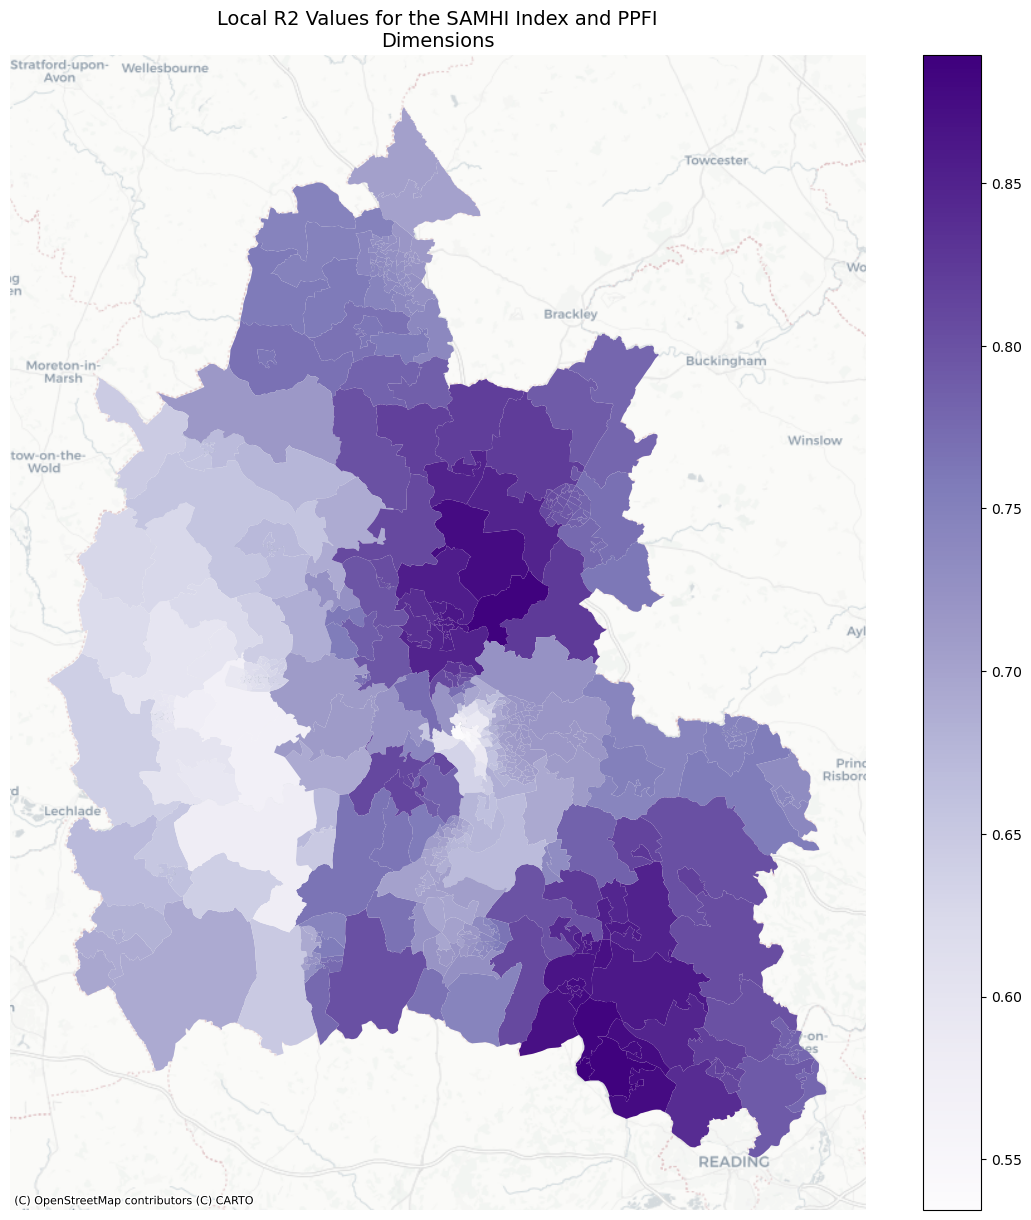

In [95]:
# add the local R2 values column to the merged dataframe
ppfi_Ox_Reordered['R2'] = gwr_results.localR2

# define custom color map for R2
vmin = ppfi_Ox_Reordered['R2'].min()
vmax = ppfi_Ox_Reordered['R2'].max()
norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter = (vmin+vmax)/2, vmax=vmax)

# create the plot
fig,ax = plt.subplots(figsize=(15,15))
ppfi_Ox_Reordered.to_crs('EPSG:3857').plot(ax=ax, column='R2', legend=True, cmap='Purples', norm=norm)
plt.axis('off')
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
title = 'Local R2 Values for the SAMHI Index and PPFI Dimensions'
wrapped_title = '\n'.join(textwrap.wrap(title,45))
plt.title(wrapped_title, fontsize=14)
plt.show()

### Explore the coefficient estimates by creating a dataframe containing all the values 

In [96]:
# Create a table for the Model coefficients and intercept values
model_parameters_SAMHI = pd.DataFrame(gwr_results.params, 
                               columns = ['Intercept','Supermarket Proximity', 'Supermarket Accessibility',
                                           'Non-Supermarket Proximity', 'Fuel Poverty',
                                           'Socio-demographic Barriers', 'Food Support for Families',
                                            'E-Commerce Access']
                                           )

# add the geometry and LSOA columns to the model parameters dataframe
model_parameters_SAMHI = model_parameters_SAMHI.assign(LSOA21CD = ppfi_Ox_Reordered['LSOA21CD'])
model_parameters_SAMHI = model_parameters_SAMHI.assign(LSOA21NM = ppfi_Ox_Reordered['LSOA21NM'])
model_parameters_SAMHI = model_parameters_SAMHI.assign(Area = ppfi_Ox_Reordered['Area'])
model_parameters_SAMHI = model_parameters_SAMHI.assign(geometry = ppfi_Ox_Reordered['geometry'])
model_parameters_SAMHI = model_parameters_SAMHI.assign(localR2 = ppfi_Ox_Reordered['R2'])
model_parameters_SAMHI = model_parameters_SAMHI.assign(District = ppfi_Ox_Reordered['District'])

### Create a summary of the model parameters for each of the five districts

In [97]:
Districts_modelParams = model_parameters_SAMHI[['Intercept', 'Supermarket Proximity', 'Supermarket Accessibility',
       'Non-Supermarket Proximity', 'Fuel Poverty',
       'Socio-demographic Barriers', 'Food Support for Families',
       'E-Commerce Access','District']].groupby('District').agg(['mean','median']).round(3)

Districts_modelParams.to_excel("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/GWR Outputs/GWR with SAMHI.xlsx",
                              sheet_name = "Model 2 District-Level Summary")

### Convert the created dataframe to a GeoPandas one for creating maps

In [98]:
model_parameters_SAMHI = gpd.GeoDataFrame(model_parameters_SAMHI, geometry='geometry')

### Create maps of the estimated coefficients

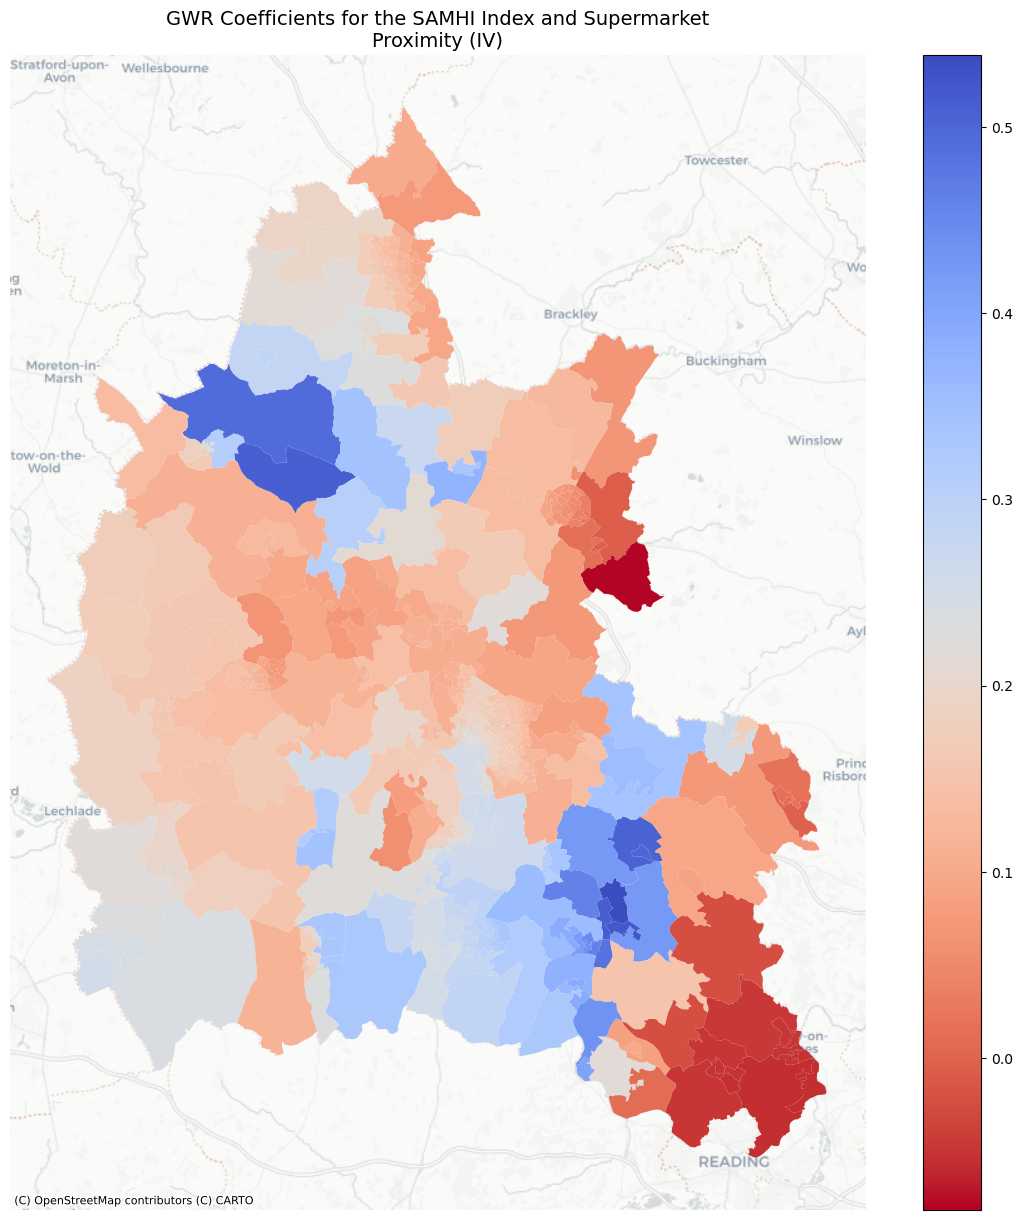

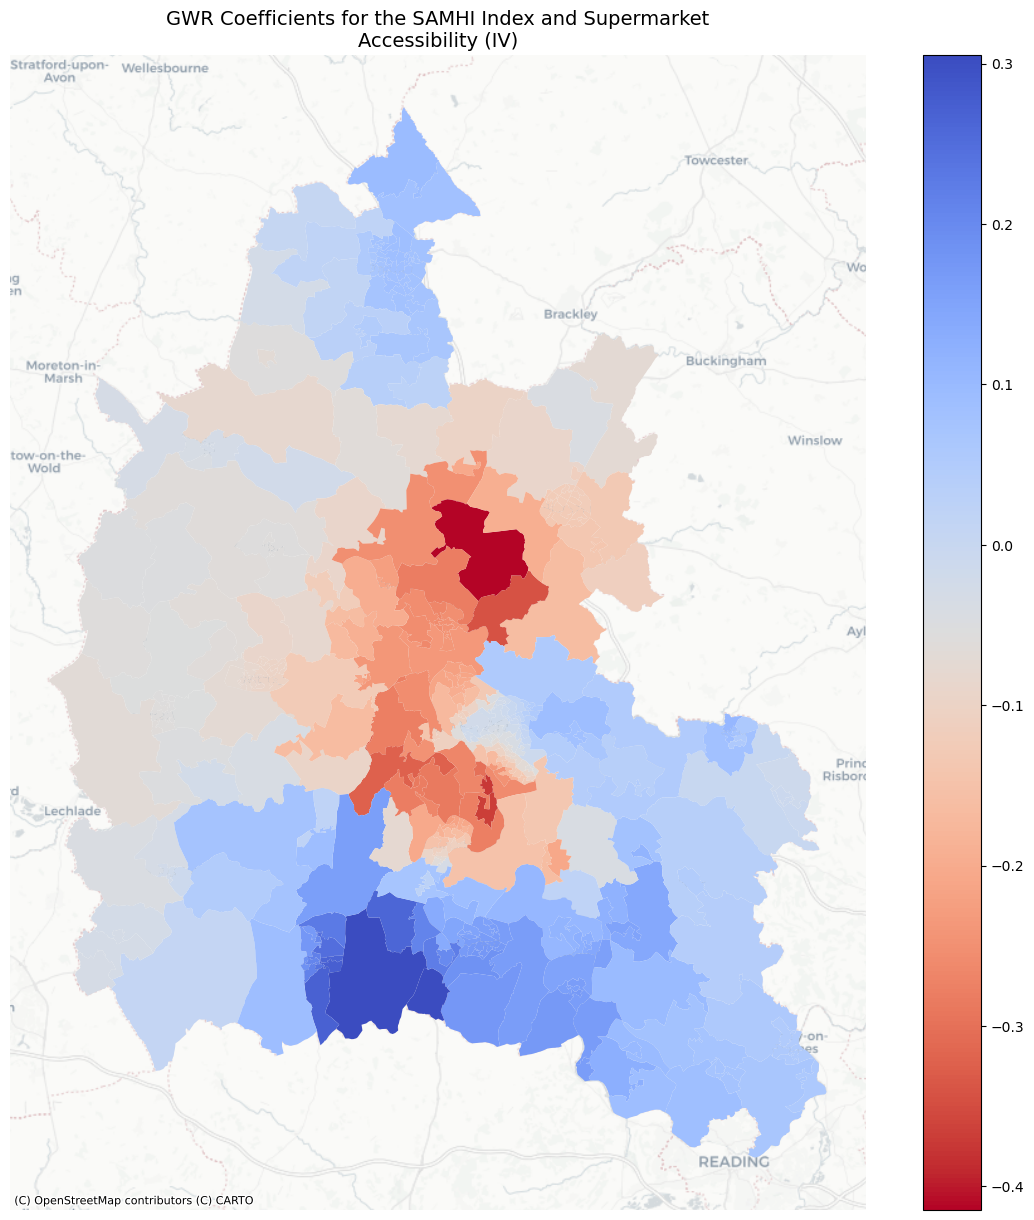

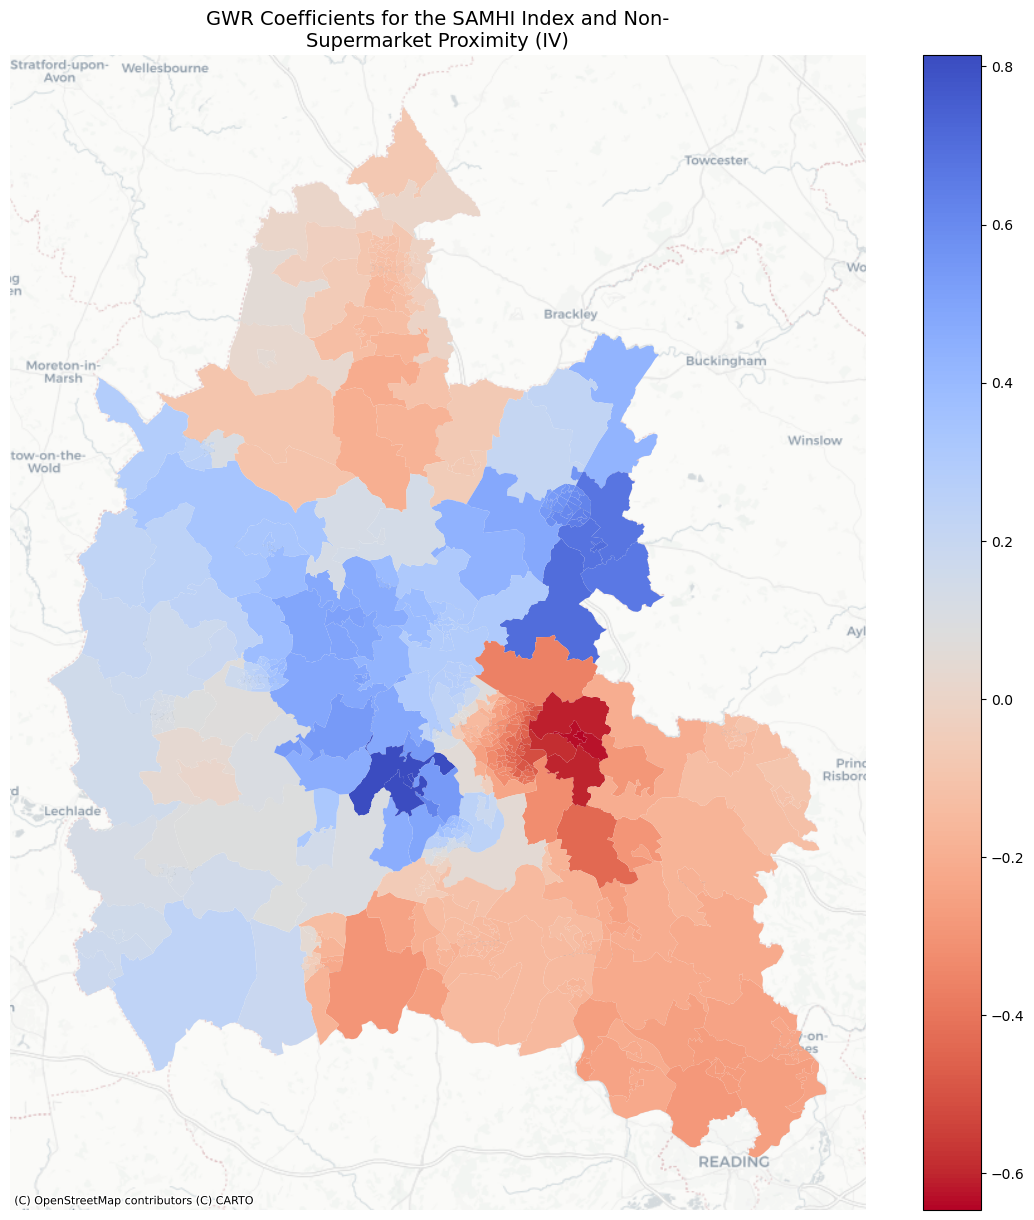

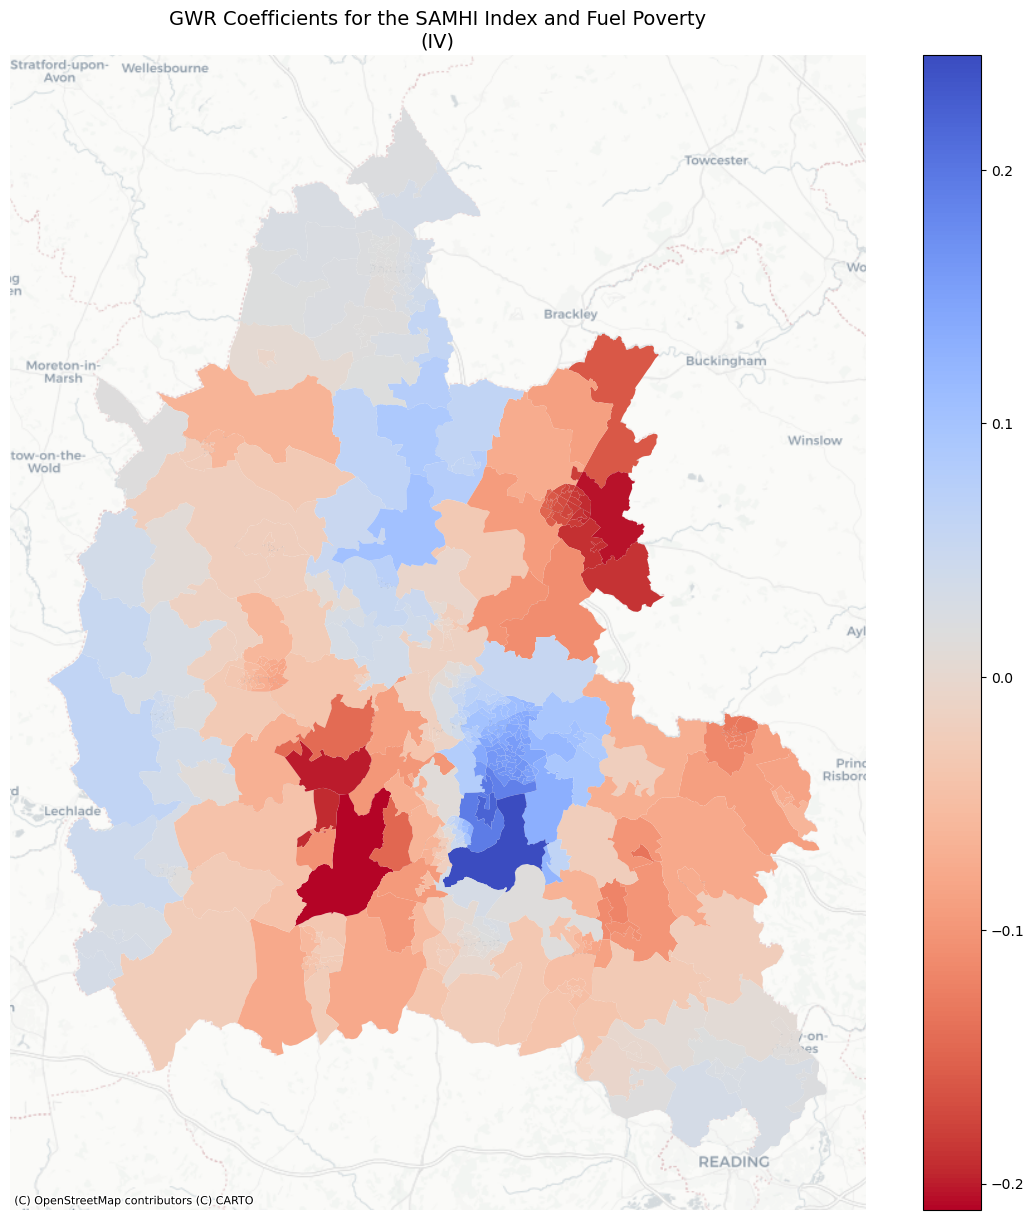

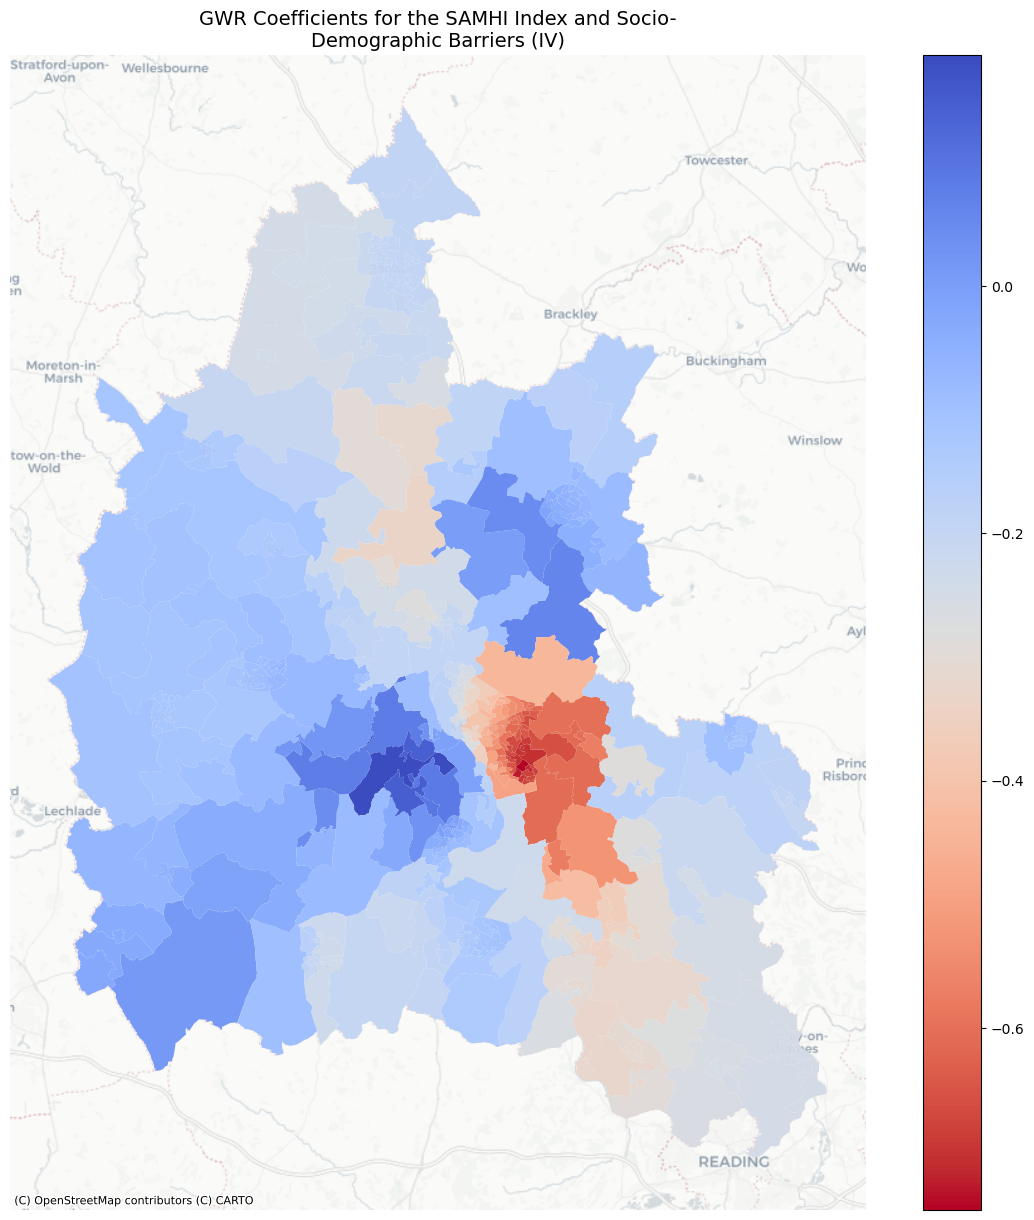

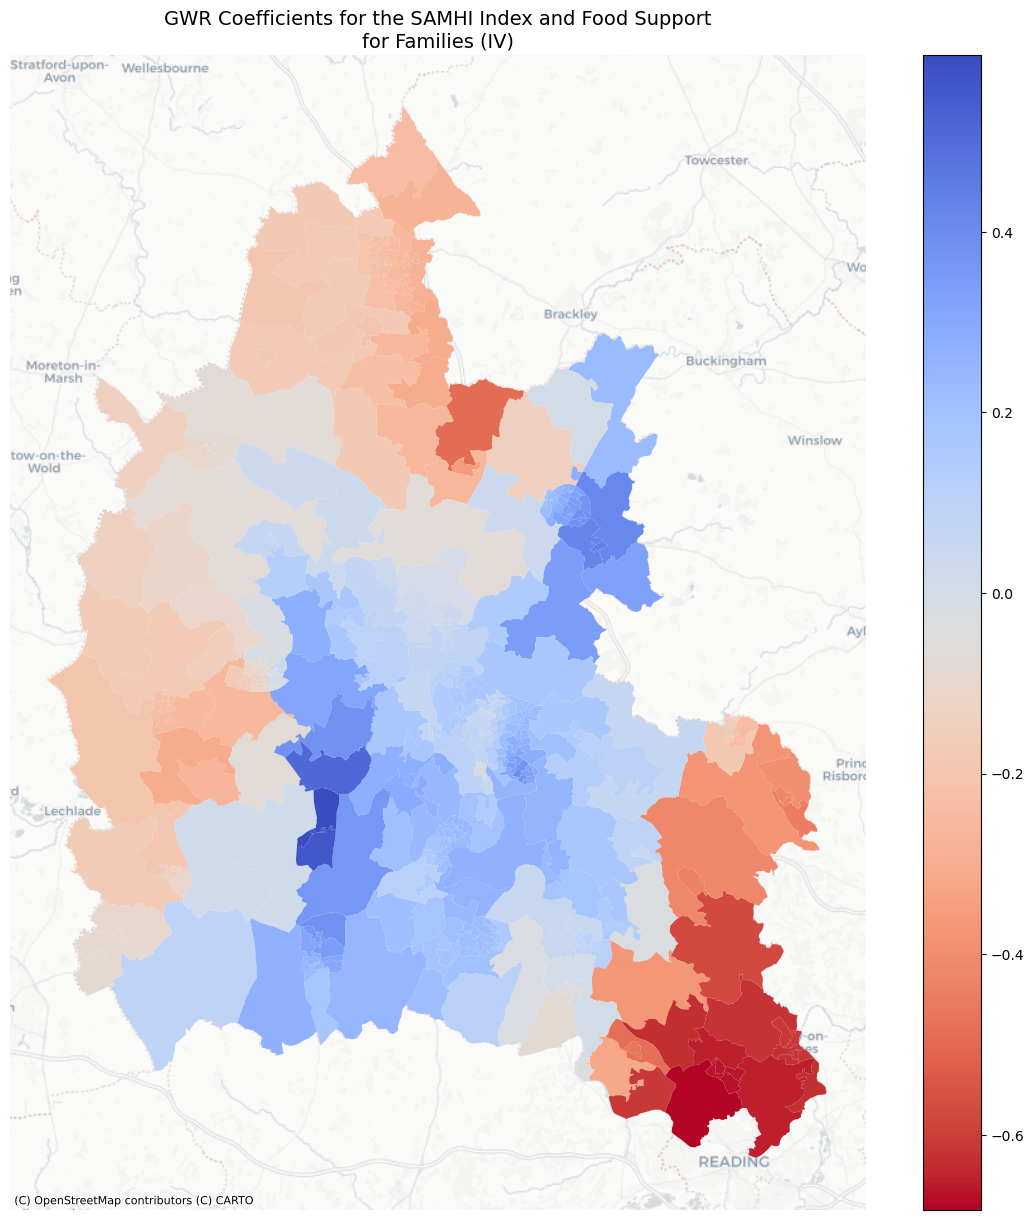

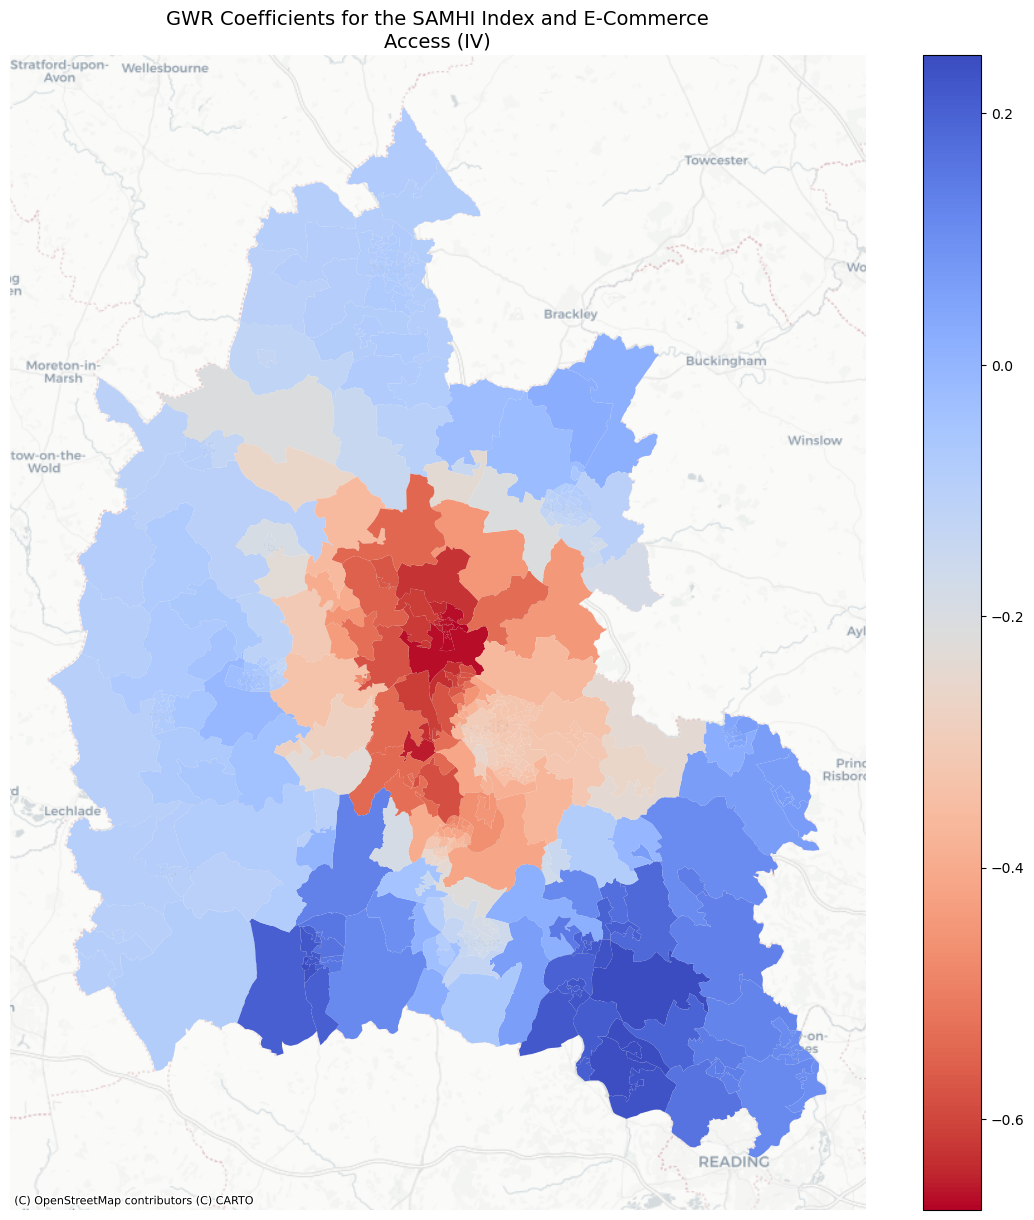

In [99]:
cols = ['Supermarket Proximity', 'Supermarket Accessibility',
       'Non-Supermarket Proximity', 'Fuel Poverty',
       'Socio-demographic Barriers', 'Food Support for Families',
       'E-Commerce Access']
titles = ['Supermarket Proximity', 'Supermarket Accessibility', 'Non-Supermarket Proximity', 'Fuel Poverty',
         'Socio-Demographic Barriers','Food Support for Families', 'E-Commerce Access']

for i,col,title in zip(range(len(cols)),cols,titles):
    fig,ax = plt.subplots(figsize=(15,15))
    
    # define custom color map for the coefficients
    vmin = model_parameters_SAMHI[col].min()
    vmax = model_parameters_SAMHI[col].max()
    norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter = (vmin+vmax)/2, vmax=vmax)
    
    model_parameters_SAMHI.to_crs('EPSG:3857').plot(ax=ax, column=col, legend=True, cmap='coolwarm_r',
                                                        norm=norm)
    title = f"GWR Coefficients for the SAMHI Index and {title} (IV)"
    wrapped_title = '\n'.join(textwrap.wrap(title,55))
    plt.title(wrapped_title, fontsize=14)
    ax.set_axis_off()
    ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
    plt.show()

### Define a color map for the significant coefficient estimates

In [100]:
# define a color map with white at zero
vmin = -2
vmax = 1
norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap="RdBu_r"

## Explore Model Diagnostics

### Check the summary of the model results

In [101]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 428
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1254.533
Log-likelihood:                                                    -837.440
AIC:                                                               1690.881
AICc:                                                              1693.311
BIC:                                                              -1290.299
R2:                                                                   0.351
Adj. R2:                                                              0.340

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Generate a Statistical Summary of the Model Parameters

In [102]:
parameters_summary = pd.DataFrame()
col_names = ['Intercept', 'Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
            'Fuel Poverty','Socio-Demographic Barriers','Family Food Support','E-Commerce Access']
lst = ['Mean','STD','Min','Median','Max']
parameters_summary['Variable'] = col_names

mean_values = []
sd_values = []
min_values = []
median_values = []
max_values = []

gwr_results_df = pd.DataFrame(gwr_results.params)

for i in range(8):
    mean = gwr_results_df[i].mean()
    mean_values.append(round(mean,3))
    
    std = gwr_results_df[i].std()
    sd_values.append(round(std,3))
    
    minimum = gwr_results_df[i].min()
    min_values.append(round(minimum,3))
    
    maximum = gwr_results_df[i].max()
    max_values.append(round(maximum,3))
    
    median = gwr_results_df[i].median()
    median_values.append(round(median,3))

parameters_summary['Mean'] = mean_values
parameters_summary['STD'] = sd_values
parameters_summary['Min'] = min_values
parameters_summary['Median'] = median_values
parameters_summary['Max'] = max_values

### Export the Parameters Summary to an Excel file

In [103]:
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/GWR Outputs/GWR with SAMHI.xlsx",
                   engine="openpyxl", mode="a") as writer:
    parameters_summary.to_excel(writer, sheet_name = "Model 2 Parameters Summary")


### Define a formatting style for the plots to come

In [104]:
kwargs = {'edgecolor':'black',
         'linewidth':0.5
         }

### Visualize the Statistical Significance of Parameter Estimates

In [105]:
# default behaviour using corrected alpha
filter_tc = gwr_results.filter_tvals()

# without correction using common alpha
filter_t = gwr_results.filter_tvals(alpha=0.05)

# create a dataframe for the parameter estimates
parameter_estimates = pd.DataFrame()

# column names used to loop through and capture the model estimates
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
            'Fuel Poverty','Socio-Demographic Barriers','Family Food Support','E-Commerce Access']

# loop through to capture the parameter estimates
for col,i in list(zip(columns_significance, range(1,8))):
    parameter_estimates[col] = gwr_results.params[:,i]
    parameter_estimates[col+"_t"] = filter_t[:,i]
    parameter_estimates[col+"_tc"] = filter_tc[:,i]

# add other useful columns 
parameter_estimates[['LSOA21CD','LSOA21NM','Area','geometry','District']] = ppfi_Ox_Reordered[['LSOA21CD','LSOA21NM','Area','geometry','District']]

# convert the merged dataframe to a GeoPandas one
parameter_estimates = gpd.GeoDataFrame(parameter_estimates, geometry='geometry').to_crs('EPSG:3857')

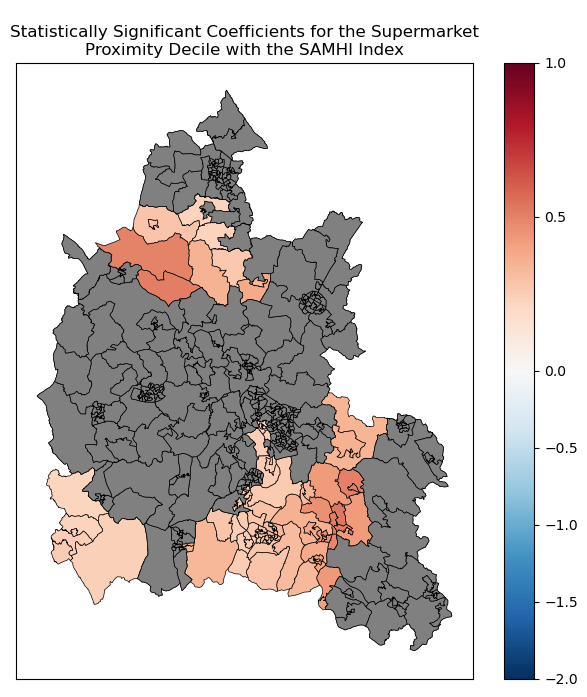

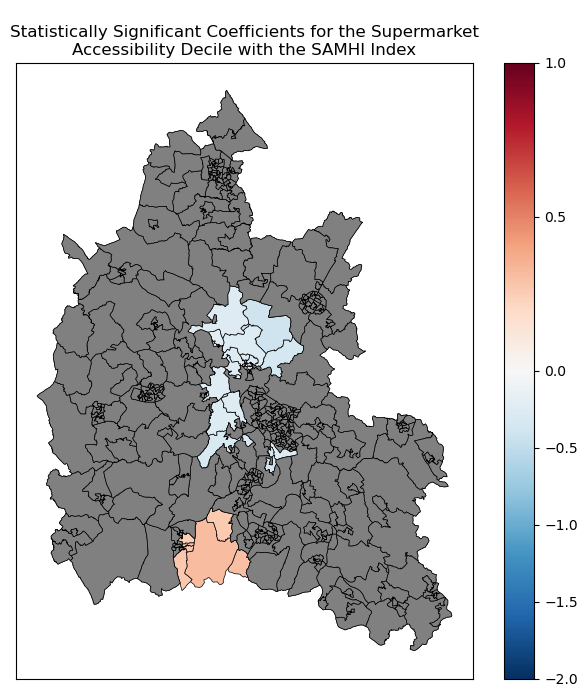

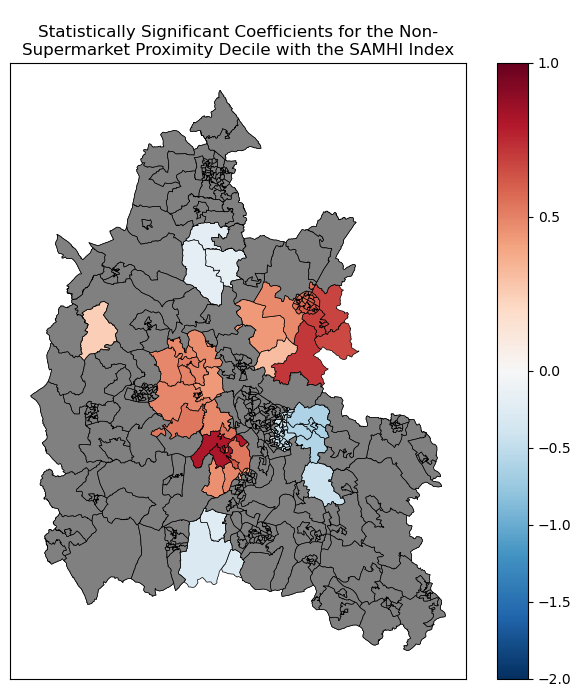

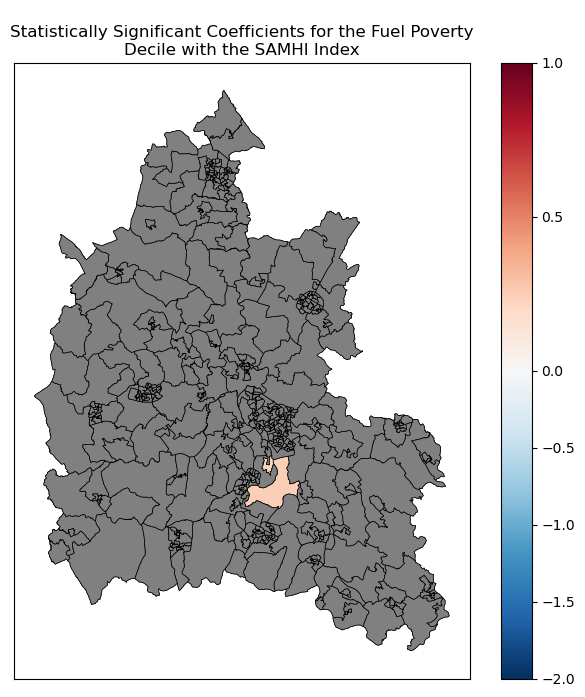

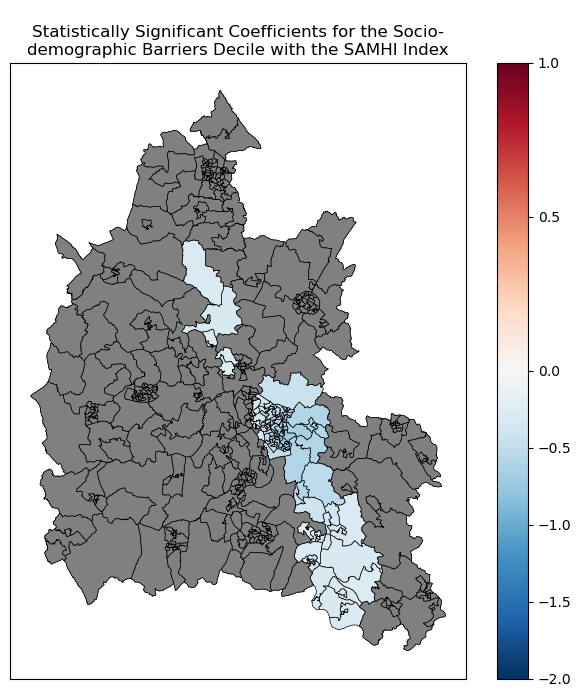

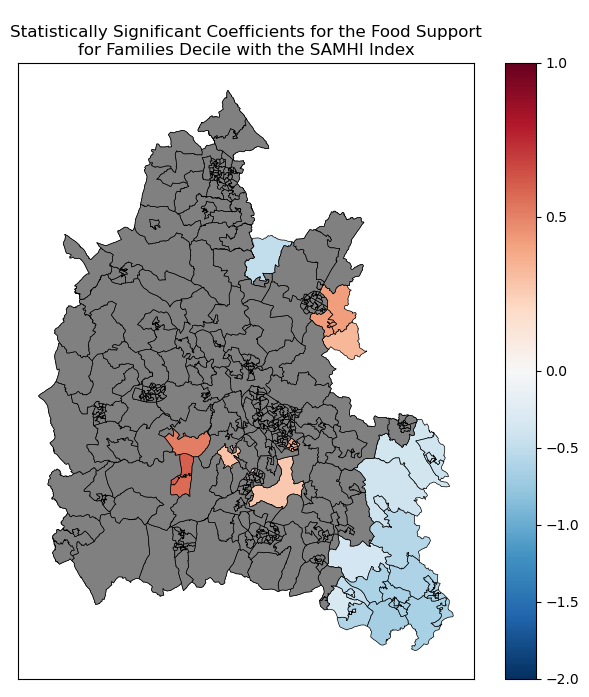

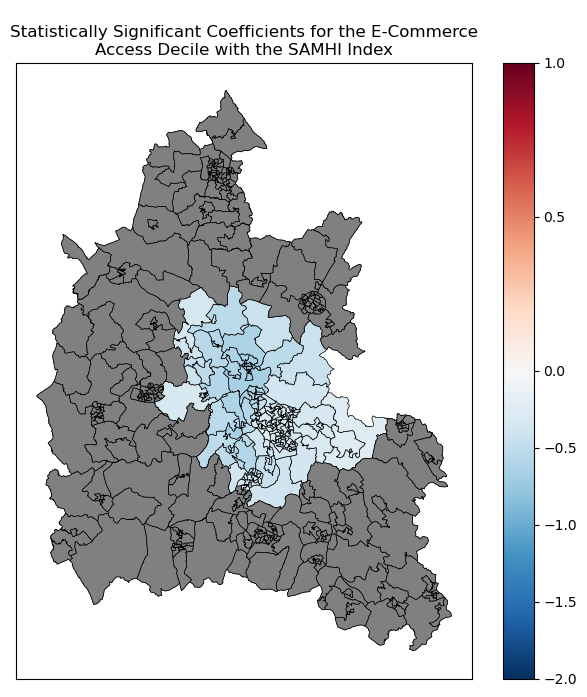

In [106]:
# define a list of column names used to generate the maps
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
            'Fuel Poverty','Socio-Demographic Barriers','Family Food Support','E-Commerce Access']

# define a list of dimension names to used to set titles for the maps
title_dimensions = ['Supermarket Proximity',
                   'Supermarket Accessibility',
                   'Non-Supermarket Proximity',
                   'Fuel Poverty',
                   'Socio-demographic Barriers',
                    'Food Support for Families',
                   'E-Commerce Access']

# create the maps
for col,title in list(zip(columns_significance,title_dimensions)):
    fig,ax = plt.subplots(figsize=(8,8))
    parameter_estimates.plot(
    col,
    ax=ax,
    legend=True,
    **kwargs,
    cmap=cmap,
    norm=norm
    )
    parameter_estimates[parameter_estimates[col+'_tc'] == 0].plot(ax=ax,
                                                                 color='grey',
                                                                 **kwargs)
    title = f"Statistically Significant Coefficients for the {title} Decile with the SAMHI Index"
    ax.set_title("\n".join(textwrap.wrap(title,60)))                                                             
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [107]:
# define a list of dimensions names used to capture the parameter estimates
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
                        'Fuel Poverty','Socio-Demographic Barriers',
                        'Family Food Support','E-Commerce Access']

# define a dictionnary showing the district names and the total LSOAs (2011) count of each to add that 
# to the district summaries
LSOAs_Count = {
    "Cherwell":102,
    "South Oxfordshire":93,
    "West Oxfordshire":68,
    "Vale of White Horse":81,
    "Oxford":85
}

# define a list of excel worksheet names for exporting later
sheet_names = ['SM_Prox','SM_Acc','NonSM_Prox','FuelPov','SD','FFF','E_Comm']

# list of statistical measures
lst = ['Mean','Median','LSOA_Count','Minimum','Maximum']

# create the statistical summary
for col,sheet_name in zip(columns_significance, sheet_names):
    district_estimates = parameter_estimates[parameter_estimates[col+"_tc"] !=0].groupby('District').agg(
        LSOA_Count=('LSOA21CD','nunique'),
        Mean=(col,'mean'),
        Median = (col,'median'),
        Minimum = (col,'min'),
        Maximum = (col,'max'),
    ).reset_index()
    district_estimates['Total_LSOAs'] = district_estimates['District'].map(LSOAs_Count)
    district_estimates['LSOA_Coverage'] = round(district_estimates['LSOA_Count']/district_estimates['Total_LSOAs']*100,2)
    district_estimates[lst] = district_estimates[lst].round(3)
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/GWR Outputs/GWR with SAMHI.xlsx",
                   engine="openpyxl", mode="a") as writer:
        district_estimates.to_excel(writer, sheet_name = f"Summary_{sheet_name}")

### Get the significant LSOAs list for each District and Dimension

In [108]:
for col, sheet_name in zip(columns_significance, sheet_names):
    Sig_LSOA_list = parameter_estimates[parameter_estimates[col+"_tc"] != 0].round(3)
    Sig_LSOA_list = Sig_LSOA_list[['LSOA21CD','LSOA21NM','Area','District',col]].merge(Ox_dem[['LSOA21CD','LSOA21NM','RUC11']], 
                                                                             on='LSOA21CD',how='inner').reset_index()
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/GWR Outputs/GWR with SAMHI.xlsx",
                   engine="openpyxl", mode="a") as writer:
        Sig_LSOA_list.to_excel(writer, sheet_name = f"Sig_{sheet_name}")

### Group the district-level estimates of LSOAs by the RUC classification

In [109]:
# create a dictionnary of the Cherwell LSOAs count by RUC classification 
District_RUC_LSOA_Count = {
    "Cherwell":{
        "Urban city and town": 69,
        "Rural village and dispersed": 26,
        "Rural town and fringe": 7
    },
    "South Oxfordshire":{
        "Urban city and town": 49,
        "Rural village and dispersed": 21,
        "Rural town and fringe": 23
    },
    "West Oxfordshire":{
        "Urban city and town": 28,
        "Rural village and dispersed": 19,
        "Rural town and fringe": 21
    },
    "Oxford":{
        "Urban city and town": 84,
        "Rural village and dispersed": 0,
        "Rural town and fringe": 1
    },
    "Vale of White Horse":{
        "Urban city and town": 49,
        "Rural village and dispersed": 10,
        "Rural town and fringe": 22
    }
}

# define a function to get the LSOA count values from the dictionnary defined above
def get_value(row):
    return District_RUC_LSOA_Count[row["District"]][row['RUC11']]

# create the dataframe
for col, sheet_name in zip(columns_significance, sheet_names):
    Grouped_RUC = parameter_estimates[parameter_estimates[col+"_tc"] != 0]
    Grouped_RUC = Grouped_RUC[['LSOA21CD','District',col]].merge(Ox_dem[['LSOA21CD','RUC11']], on='LSOA21CD', how='inner')
    Grouped_RUC = Grouped_RUC.groupby(['District','RUC11']).agg(
        LSOA_Count = ('LSOA21CD','nunique'),
        Coeff_Average = (col,'mean')
    ).reset_index()
    Grouped_RUC['Total_LSOAs'] = Grouped_RUC.apply(get_value, axis=1)
    Grouped_RUC['LSOA_Coverage'] = round(Grouped_RUC['LSOA_Count']/Grouped_RUC['Total_LSOAs']*100,2)
    Grouped_RUC['Coeff_Average'] = round(Grouped_RUC['Coeff_Average'],3)
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/GWR Outputs/GWR with SAMHI.xlsx", engine="openpyxl", mode="a") as writer:
        Grouped_RUC.to_excel(writer, sheet_name = f"Sig_RUC_{sheet_name}")

## Fit a GWR model with the SAMHI index as the dependent variable and the PPFI combined decile as the independent variable

### Define the variables

In [110]:
# define the dependent variable as the SAMHI decile
y = ppfi_Ox_Reordered['samhi_dec'].values.reshape(-1,1)

# define the independent variables as the dimensions of the PPFI
X = ppfi_Ox_Reordered[['PPFI Combined Decile']].values

y = np.array(y)
X = np.array(X)

### Define the coordinates

In [111]:
u = points.x
v = points.y
coords = list(zip(u,v))

### Calibrate the model

In [112]:
gwr_selector = Sel_BW(coords, y, X, kernel='bisquare')
gwr_bw = gwr_selector.search()
print(gwr_bw)

45.0


### Fit the model

In [113]:
gwr_model = GWR(coords, y, X, bw=gwr_bw, kernel='bisquare')

### Get the results

In [ ]:
gwr_results = gwr_model.fit()

### Get the global R-squared

In [ ]:
global_R2 = gwr_results.R2
print(global_R2)

## Model Diagnostics

### View the statistical summary of the model results

In [ ]:
gwr_results.summary()

### Create a statistical summary of the model parameters

In [ ]:
parameters_summary = pd.DataFrame()
col_names = ['Intercept', 'Combined Decile']
lst = ['Mean','STD','Min','Median','Max']
parameters_summary['Variable'] = col_names

mean_values = []
sd_values = []
min_values = []
median_values = []
max_values = []

gwr_results_df = pd.DataFrame(gwr_results.params)

for i in range(2):
    mean = gwr_results_df[i].mean()
    mean_values.append(round(mean,3))
    
    std = gwr_results_df[i].std()
    sd_values.append(round(std,3))
    
    minimum = gwr_results_df[i].min()
    min_values.append(round(minimum,3))
    
    maximum = gwr_results_df[i].max()
    max_values.append(round(maximum,3))
    
    median = gwr_results_df[i].median()
    median_values.append(round(median,3))

parameters_summary['Mean'] = mean_values
parameters_summary['STD'] = sd_values
parameters_summary['Min'] = min_values
parameters_summary['Median'] = median_values
parameters_summary['Max'] = max_values

### Export the statistical Summary to an Excel file

In [ ]:
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/GWR Outputs/GWR with SAMHI.xlsx",
                   engine="openpyxl", mode="a") as writer:
    parameters_summary.to_excel(writer, sheet_name = "Model 1 Parameters Summary")

### Visualize the Statistical Significance of Parameter Estimates

In [ ]:
# default behaviour using corrected alpha
filter_tc = gwr_results.filter_tvals()

# without correction using common alpha
filter_t = gwr_results.filter_tvals(alpha=0.05)

# create a dataframe for the parameter estimates
parameter_estimates = pd.DataFrame()

# capture the parameter estimates
parameter_estimates['PPFI Combined Decile'] = gwr_results.params[:,1]
parameter_estimates['PPFI Combined Decile_t'] = filter_t[:,1]
parameter_estimates['PPFI Combined Decile_tc'] = filter_tc[:,1]

# add other useful columns 
parameter_estimates[['LSOA21CD','LSOA21NM','Area','geometry','District']] = ppfi_Ox_Reordered[['LSOA21CD','LSOA21NM','Area','geometry','District']]

# convert the merged dataframe to a GeoPandas one
parameter_estimates = gpd.GeoDataFrame(parameter_estimates, geometry='geometry').to_crs('EPSG:3857')

In [ ]:
# generate the map of the statistically significant parameter estimates
fig,ax = plt.subplots(figsize=(8,8))

parameter_estimates.plot(
    'PPFI Combined Decile',
    ax=ax,
    legend=True,
    **kwargs,
    cmap=cmap,
    norm=norm
)

parameter_estimates[filter_tc[:,1] == 0].plot(ax=ax,
                                              color='grey',
                                            **kwargs
                                             )
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = f"Statistically Significant Coefficients for the Combined Decile with the SAMHI decile"
ax.set_title("\n".join(textwrap.wrap(title,60)))  
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)

plt.show()

In [ ]:
district_estimates = parameter_estimates[filter_tc[:,1] !=0].groupby('District').agg(LSOA_Count = ('LSOA21CD','nunique'),
                                            Mean = ('PPFI Combined Decile','mean'),
                                            Median = ('PPFI Combined Decile','median'),
                                            Minimum = ('PPFI Combined Decile','min'),
                                            Maximum = ('PPFI Combined Decile','max')
                                                                                    ).reset_index()
lst = ['LSOA_Count','Mean','Median','Minimum','Maximum']
district_estimates[lst] = district_estimates[lst].round(3)
LSOAs_Count = {
    "Cherwell":102,
    "South Oxfordshire":93,
    "West Oxfordshire":68,
    "Vale of White Horse":81,
    "Oxford":85
}
def get_value(row):
    return LSOAs_Count[row]
district_estimates['Total_LSOAs'] = district_estimates['District'].apply(get_value)
district_estimates['LSOA_Coverage'] = round(district_estimates['LSOA_Count']/district_estimates['Total_LSOAs']*100,3)
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/GWR Outputs/GWR with SAMHI.xlsx",
                   engine="openpyxl", mode="a") as writer:
    district_estimates.to_excel(writer, sheet_name = "Model 1_Sig")

## Checking for Multicollinearity in the model with the dimensions as independent variables

In [ ]:
# create a copy of the merged dataframe
ppfi_Ox_Reordered_copy = ppfi_Ox_Reordered.copy()

In [ ]:
cols = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
        'Fuel Poverty','Socio-demographic Barriers',
        'Food Support for Families','E-Commerce Access']

# define the dependent variable as the SAMHI decile
y = ppfi_Ox_Reordered_copy['samhi_dec'].values.reshape(-1,1)

# define the independent variables as the dimensions of the PPFI
X = ppfi_Ox_Reordered_copy[cols].values

y = np.array(y)
X = np.array(X)

# Define the u and v coordinates
u = points.x
v = points.y
coords = list(zip(u,v))

# Model calibration
gwr_selector = Sel_BW(coords, y, X, kernel='bisquare')
gwr_bw = gwr_selector.search()

# Fit the model
gwr_model = GWR(coords, y, X, bw=gwr_bw, kernel='bisquare')

# get the results
gwr_results = gwr_model.fit()

# capture the multicollinearity measures
LCC,VIF,CN,VDP = gwr_results.local_collinearity()

# define the list of map titles
names = [   
    'Supermarket Proximity vs Supermarket Accessibility',
    'Supermarket Proximity vs Non-Supermarket Proximity',
    'Supermarket Proximity vs Fuel Poverty',
    'Supermarket Proximity vs Socio-demographic Barriers',
    'Supermarket Proximity vs Food Support for Families',
    'Supermarket Proximity vs E-Commerce Access',
    'Supermarket Accessibility vs Non-Supermarket Proximity',
    'Supermarket Accessibility vs Fuel Poverty',
    'Supermarket Accessibility vs Socio-demographic Barriers',
    'Supermarket Accessibility vs Food Support for Families',
    'Supermarket Accessibility vs E-Commerce Access',
    'Non-Supermarket Proximity vs Fuel Poverty',
    'Non-Supermarket Proximity vs Socio-demographic Barriers',
    'Non-Supermarket Proximity vs Food Support for Families',
    'Non-Supermarket Proximity vs E-Commerce Access',
    'Fuel Poverty vs Socio-demographic Barriers',
    'Fuel Poverty vs Food Support for Families',
    'Fuel Poverty vs E-Commerce Access',
    'Socio-demographic Barriers vs Food Support for Families',
    'Socio-demographic Barriers vs E-Commerce Access',
    'Food Support for Families vs E-Commerce Access'
]

# create the maps for LCC
fig,ax = plt.subplots(1,21,figsize=(100,10))
for col in range(21):
    ppfi_Ox_Reordered_copy['lcc'] = LCC[:,col]
    ppfi_Ox_Reordered_copy.plot('lcc',ax=ax[col], legend=True, cmap='coolwarm')
    ax[col].get_xaxis().set_visible(False)
    ax[col].get_yaxis().set_visible(False)
    ax[col].set_title('LCC: ' + names[col], fontsize=6)


# define the names of the independent variables
names = ['Supermarket Proximity',
        'Supermarket Accessibility',
        'Non-Supermarket Proximity',
        'Fuel Poverty',
        'Socio-Demographic Barriers',
        'Food Support for Families',
        'E-Commerce Access']

# create the maps for VIF
fig,ax = plt.subplots(1,7,figsize=(100,10))
for col in range(7):
    ppfi_Ox_Reordered_copy['vif'] = VIF[:, col]
    ppfi_Ox_Reordered_copy.plot('vif', ax=ax[col], legend=True, cmap='coolwarm')
    ax[col].set_title('VIF: ' + names[col], fontsize=6)
    ax[col].get_xaxis().set_visible(False)
    ax[col].get_yaxis().set_visible(False)

# create the maps for CN
fig,ax = plt.subplots(1,1,figsize=(4,4))
ppfi_Ox_Reordered_copy['cn'] = CN
ppfi_Ox_Reordered_copy.plot('cn', legend=True, ax=ax, cmap='coolwarm')
ax.set_title('Condition Number')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
names = ['Intercept',
        'Supermarket Proximity',
        'Supermarket Accessibility',
        'Non-Supermarket Proximity',
        'Fuel Poverty',
        'Socio-demographic Barriers',
        'Food Support for Families',
        'E-Commerce Access']

# create the maps for VDP
fig,ax = plt.subplots(1,8,figsize=(100,10))
for col in range(8):
    ppfi_Ox_Reordered_copy['vdp'] = VDP[:, col]
    ppfi_Ox_Reordered_copy.plot('vdp', ax=ax[col], legend=True, cmap='coolwarm')
    ax[col].get_xaxis().set_visible(False)
    ax[col].get_yaxis().set_visible(False)
    ax[col].set_title('VDP: ' + names[col], fontsize=6)